In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline, CustomFilter, CustomFactor
from quantopian.pipeline.data import Fundamentals 
from quantopian.pipeline.data import factset
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.classifiers.morningstar import Sector 
from quantopian.pipeline.filters import QTradableStocksUS, Q1500US, Q500US
from quantopian.pipeline.filters.eventvestor import IsAnnouncedAcqTarget
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits as st
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Latest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.mstats import winsorize
from zipline.utils.numpy_utils import ( repeat_first_axis, repeat_last_axis )

In [2]:
from quantopian.pipeline.factors import ( CustomFactor, BusinessDaysSincePreviousEvent, 
                                         BusinessDaysUntilNextEvent, SimpleMovingAverage, 
                                         AverageDollarVolume, Returns, RSI, 
                                         RollingLinearRegressionOfReturns, RollingSpearmanOfReturns, 
                                         AnnualizedVolatility, Returns, DailyReturns)

In [3]:
import talib
import pandas as pd
import numpy as np
from time import time

In [4]:
import alphalens as al
import pyfolio as pf
from scipy import stats
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [5]:
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from sklearn.metrics import classification_report
from quantopian.interactive.data.quandl import fred_dgs10

In [6]:
WIN_LIMIT = 0.0

In [7]:
def preprocess(a):
    
    a = np.nan_to_num(a - np.nanmean(a))
    
    a = winsorize(a, limits=[WIN_LIMIT,WIN_LIMIT])

    return preprocessing.scale(a)

In [8]:
def normalize(x):
    
    r = x - x.mean()
    denom = r.abs().sum()
    
    return r/denom

In [9]:
def z_score(x):
    
    z = (x - x.mean()) / x.std()
    
    return z 

In [10]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

In [11]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios

In [12]:
has_data = (bs.working_capital.latest.notnull()
            & bs.total_assets.latest.notnull()
            & or_.roic.latest.notnull()
            & morningstar.cash_flow_statement.operating_cash_flow.latest.notnull()
            & EarningsSurprises.eps_act.latest.notnull()
            & is_.ebit.latest.notnull()
            & is_.ebitda.latest.notnull()
            & cfs.capital_expenditure.latest.notnull()
            & cfs.free_cash_flow.latest.notnull()
            & bs.common_stock_equity.latest.notnull()
)

In [13]:
is_tradeable = (QTradableStocksUS()
                & has_data )

In [14]:
universe = is_tradeable

In [15]:
def make_factors():
    
        class atr_10days_percent_z(CustomFactor):  
            inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]  
            window_length = 11  
            def compute(self, today, assets, out, high, low, close):  
                range_low = np.maximum(high[1:], close[:-1]) 
                range_high = np.minimum(low[1:], close[:-1])  
                out[:] = z_score(np.mean(((range_high - range_low)/close[:-1])*100, axis=0))
                
        class fcf(CustomFactor):
            inputs = [Fundamentals.fcf_yield]
            window_length = 1
            def compute(self, today, assets, out, fcf_yield):
                out[:] = preprocess(np.nan_to_num(fcf_yield[-1,:]))
                
        class Direction(CustomFactor):
            inputs = [USEquityPricing.open, USEquityPricing.close]
            window_length = 21
            def compute(self, today, assets, out, open, close):
                p = (close-open)/close
                out[:] = preprocess(np.nansum(-p,axis=0))
                
        class mean_rev(CustomFactor):   
            inputs = [USEquityPricing.high,USEquityPricing.low,USEquityPricing.close]
            window_length = 30
            def compute(self, today, assets, out, high, low, close):
            
                p = (high+low+close)/3

                m = len(close[0,:])
                n = len(close[:,0])
                
                b = np.zeros(m)
                a = np.zeros(m)
                
                for k in range(10,n+1):
                    price_rel = np.nanmean(p[-k:,:],axis=0)/p[-1,:]
                    wt = np.nansum(price_rel)
                    b += wt*price_rel
                    price_rel = 1.0/price_rel
                    wt = np.nansum(price_rel)
                    a += wt*price_rel
                
                out[:] = preprocess(b-a)
                
        class volatility(CustomFactor):
            inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, USEquityPricing.volume]
            window_length = 5
            def compute(self, today, assets, out, high, low, close, volume):
                vol = np.nansum(volume,axis=0)*np.nansum(np.absolute((high-low)/close),axis=0)
                out[:] = preprocess(-vol)
                
        class growthscore(CustomFactor):
            inputs = [Fundamentals.growth_score]
            window_length = 1
            def compute(self, today, assets, out, growth_score):
                out[:] = preprocess(growth_score[-1,:])
                
        class peg_ratio(CustomFactor):
            inputs = [Fundamentals.peg_ratio]
            window_length = 1
            def compute(self, today, assets, out, peg_ratio):
                out[:] = preprocess(-1.0/peg_ratio[-1,:])
                
        class MoneyflowVolume5d(CustomFactor):
            inputs = (USEquityPricing.close, USEquityPricing.volume)

            # we need one more day to get the direction of the price on the first
            # day of our desired window of 5 days
            window_length = 6
            
            def compute(self, today, assets, out, close_extra, volume_extra):
                # slice off the extra row used to get the direction of the close
                # on the first day
                close = close_extra[1:]
                volume = volume_extra[1:]
                
                dollar_volume = close * volume
                denominator = dollar_volume.sum(axis=0)
                
                difference = np.diff(close_extra, axis=0)
                direction = np.where(difference > 0, 1, -1)
                numerator = (direction * dollar_volume).sum(axis=0)
                
                out[:] = preprocess(-np.divide(numerator, denominator))
                
        class Trendline(CustomFactor):
            inputs = [USEquityPricing.close]
            window_length = 252
            
            _x = np.arange(window_length)
            _x_var = np.var(_x)

            def compute(self, today, assets, out, close):
            
                x_matrix = repeat_last_axis(
                (self.window_length - 1) / 2 - self._x,
                len(assets),
                )

                y_bar = np.nanmean(close, axis=0)
                y_bars = repeat_first_axis(y_bar, self.window_length)
                y_matrix = close - y_bars

                out[:] = preprocess(-np.divide(
                (x_matrix * y_matrix).sum(axis=0) / self._x_var,
                self.window_length
                ))
                
        class Revenue(CustomFactor):
            inputs = [Fundamentals.total_revenue]
            window_length = 252
            def compute(self, today, assets, out, revenue):
                out[:] = preprocess((revenue[-1] > revenue[0]).astype(int))

        class GrossMarginChange(CustomFactor):
            window_length = 126
            inputs = [Fundamentals.gross_margin]
            def compute(self, today, assets, out, gross_margin):
                out[:] = preprocess((gross_margin[-1] > gross_margin[0]).astype(int))

        class Gross_Income_Margin(CustomFactor):
            #Gross Income Margin:
            #Gross Profit divided by Net Sales
            #Notes:
            #High value suggests that the company is generating large profits
            inputs = [Fundamentals.cost_of_revenue, Fundamentals.total_revenue]
            window_length = 1
            def compute(self, today, assets, out, cost_of_revenue, sales):
                gross_income_margin = sales[-1]/sales[-1] - cost_of_revenue[-1]/sales[-1]
                out[:] = preprocess(gross_income_margin)

        class MaxGap(CustomFactor): 
            # the biggest absolute overnight gap in the previous 90 sessions
            inputs = [USEquityPricing.close] ; window_length = 90
            def compute(self, today, assets, out, close):
                abs_log_rets = np.abs(np.diff(np.log(close),axis=0))
                max_gap = np.max(abs_log_rets, axis=0)
                out[:] = preprocess(max_gap)
        
        class CapEx_Vol(CustomFactor):
            inputs=[
                Fundamentals.cap_ex_reported,
                Fundamentals.total_assets]
            window_length = 390
            def compute(self, today, assets, out, capex, total_assets):
                v = capex/total_assets
                v[np.isinf(v)] = np.nan
                out[:] = preprocess(-np.ptp(v,axis=0))
                
        class fcf_ev(CustomFactor):
            inputs=[
                Fundamentals.fcf_per_share,
                Fundamentals.shares_outstanding,
                Fundamentals.enterprise_value,]
            window_length = 1
            def compute(self, today, assets, out, fcf, shares, ev):
                v = fcf*shares/ev
                v[np.isinf(v)] = np.nan
                 
                out[:] = preprocess(v[-1])
                
        class DebtToTotalAssets(CustomFactor):
            inputs = [Fundamentals.long_term_debt,
              Fundamentals.current_debt,
              Fundamentals.cash_and_cash_equivalents,
              Fundamentals.total_assets]
            window_length = 1
            
            def compute(self, today, assets, out, ltd, std, cce, ta):
                std_part = np.maximum(std - cce, np.zeros(std.shape))
                v = np.divide(ltd + std_part, ta)
                v[np.isinf(v)] = np.nan
                out[:] = preprocess(np.ravel(v))
                                                                                             
        return {
            'atr_10days_percent_z':    atr_10days_percent_z,
            'FCF':                     fcf,
            'Direction':               Direction,
            'mean_rev':                mean_rev,
            'volatility':              volatility,
            'GrowthScore':             growthscore,
            'PegRatio':                peg_ratio,
            'MoneyFlow':               MoneyflowVolume5d,
            'Trendline':               Trendline,
            'Revenue':                 Revenue,
            'GrossMarginChange':       GrossMarginChange,
            'Gross_Income_Margin':     Gross_Income_Margin,
            'MaxGap':                  MaxGap,
            'CapEx_Vol':               CapEx_Vol,
            'fcf_ev':                  fcf_ev,
            'DebtToTotalAssets':       DebtToTotalAssets,
        }

In [16]:
factors = make_factors()

In [17]:
combined_alpha = None

for name, f in factors.iteritems():
        if combined_alpha == None:
            combined_alpha = f(mask=universe)
        else:
            combined_alpha = combined_alpha+f(mask=universe)

In [18]:
from collections import OrderedDict

def make_ml_pipeline(factors, universe):
    
    factors_pipe = OrderedDict()
    
    factors_pipe['5D_Returns'] = Returns(inputs = [USEquityPricing.close],
                                      mask = universe, window_length = 5)
        
    factors_pipe['combined_alpha'] = combined_alpha

    factors_pipe['Sector'] = Sector()
    
    for name, f in factors.iteritems():
        factors_pipe[name] = f(mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

In [19]:
ml_pipe = make_ml_pipeline(factors, universe)

In [20]:
start_timer = time()
start = pd.Timestamp("2017-01-01") 
end = pd.Timestamp("2018-01-01")

results = run_pipeline(ml_pipe, start_date=start, end_date=end)

end_timer = time()

In [21]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 49.19 secs


In [22]:
results.head()

5D_Returns     CapEx_Vol  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])   -0.005836 -2.678936e-17   
                          Equity(31 [ABAX])    0.014426 -2.678936e-17   
                          Equity(41 [ARCB])   -0.028021  7.807509e-01   
                          Equity(52 [ABM])     0.017435 -2.678936e-17   
                          Equity(53 [ABMD])    0.003830 -2.678936e-17   

                                             DebtToTotalAssets  Direction  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])          -0.325759  -1.036289   
                          Equity(31 [ABAX])          -1.364334  -0.352858   
                          Equity(41 [ARCB])          -0.775099   1.508733   
                          Equity(52 [ABM])           -0.845901   0.040713   
                          Equity(53 [ABMD])          -1.364728  -0.238945   

                                                  FCF  GrossMarginChange  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])  0.392283          -0.888614   
                          Equity(31 [ABAX])  0.023353          -0.888614   
                          Equity(41 [ARCB])  0.171173          -0.888614   
                          Equity(52 [ABM])  -0.012049           1.125349   
                          Equity(53 [ABMD]) -0.032546          -0.888614   

                                             Gross_Income_Margin  GrowthScore  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])            -0.344799     0.786900   
                          Equity(31 [ABAX])             0.236524     0.689593   
                          Equity(41 [ARCB])             0.390037    -0.636596   
                          Equity(52 [ABM])             -1.268273    -0.933819   
                          Equity(53 [ABMD])             1.193123     1.757137   

                                               MaxGap  MoneyFlow  PegRatio  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -0.659480   0.565160  0.138599   
                          Equity(31 [ABAX]) -0.226760  -0.447664  0.158225   
                          Equity(41 [ARCB]) -0.190674   0.384314  0.260590   
                          Equity(52 [ABM])  -0.143050  -0.782864  0.156349   
                          Equity(53 [ABMD]) -0.064307  -0.941034  0.034831   

                                              Revenue  Sector  Trendline  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -1.280695     311   0.534972   
                          Equity(31 [ABAX])  0.780826     206  -0.012732   
                          Equity(41 [ARCB])  0.780826     310  -0.126047   
                          Equity(52 [ABM])   0.780826     310   0.247537   
                          Equity(53 [ABMD])  0.780826     206   1.639839   

                                             atr_10days_percent_z  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])              1.120875   
                          Equity(31 [ABAX])             -0.049513   
                          Equity(41 [ARCB])             -0.588789   
                          Equity(52 [ABM])               0.720396   
                          Equity(53 [ABMD])              0.083681   

                                             combined_alpha    fcf_ev  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])       -2.366134  0.397351   
                          Equity(31 [ABAX])       -1.421105  0.039454   
                          Equity(41 [ARCB])        2.781066  0.157456   
                          Equity(52 [ABM])        -0.611273 -0.029252   
                          Equity(53 [ABMD])        2.272337 -0.037414   

                                             mean_rev  volatility  
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -0.463137   -1.303503  
                          Equity(31 [ABAX]) -0.250282    0.243676  
                          Equity(41 [ARCB])  1.328926    0.224078  
                          Equity(52 [ABM])   0.109194    0.223573  
                          Equity(53 [ABMD])  0.119772    0.230714

In [23]:
results_s = results.drop('Sector', axis=1)
results_s.head()

5D_Returns     CapEx_Vol  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])   -0.005836 -2.678936e-17   
                          Equity(31 [ABAX])    0.014426 -2.678936e-17   
                          Equity(41 [ARCB])   -0.028021  7.807509e-01   
                          Equity(52 [ABM])     0.017435 -2.678936e-17   
                          Equity(53 [ABMD])    0.003830 -2.678936e-17   

                                             DebtToTotalAssets  Direction  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])          -0.325759  -1.036289   
                          Equity(31 [ABAX])          -1.364334  -0.352858   
                          Equity(41 [ARCB])          -0.775099   1.508733   
                          Equity(52 [ABM])           -0.845901   0.040713   
                          Equity(53 [ABMD])          -1.364728  -0.238945   

                                                  FCF  GrossMarginChange  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])  0.392283          -0.888614   
                          Equity(31 [ABAX])  0.023353          -0.888614   
                          Equity(41 [ARCB])  0.171173          -0.888614   
                          Equity(52 [ABM])  -0.012049           1.125349   
                          Equity(53 [ABMD]) -0.032546          -0.888614   

                                             Gross_Income_Margin  GrowthScore  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])            -0.344799     0.786900   
                          Equity(31 [ABAX])             0.236524     0.689593   
                          Equity(41 [ARCB])             0.390037    -0.636596   
                          Equity(52 [ABM])             -1.268273    -0.933819   
                          Equity(53 [ABMD])             1.193123     1.757137   

                                               MaxGap  MoneyFlow  PegRatio  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -0.659480   0.565160  0.138599   
                          Equity(31 [ABAX]) -0.226760  -0.447664  0.158225   
                          Equity(41 [ARCB]) -0.190674   0.384314  0.260590   
                          Equity(52 [ABM])  -0.143050  -0.782864  0.156349   
                          Equity(53 [ABMD]) -0.064307  -0.941034  0.034831   

                                              Revenue  Trendline  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -1.280695   0.534972   
                          Equity(31 [ABAX])  0.780826  -0.012732   
                          Equity(41 [ARCB])  0.780826  -0.126047   
                          Equity(52 [ABM])   0.780826   0.247537   
                          Equity(53 [ABMD])  0.780826   1.639839   

                                             atr_10days_percent_z  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])              1.120875   
                          Equity(31 [ABAX])             -0.049513   
                          Equity(41 [ARCB])             -0.588789   
                          Equity(52 [ABM])               0.720396   
                          Equity(53 [ABMD])              0.083681   

                                             combined_alpha    fcf_ev  \
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])       -2.366134  0.397351   
                          Equity(31 [ABAX])       -1.421105  0.039454   
                          Equity(41 [ARCB])        2.781066  0.157456   
                          Equity(52 [ABM])        -0.611273 -0.029252   
                          Equity(53 [ABMD])        2.272337 -0.037414   

                                             mean_rev  volatility  
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -0.463137   -1.303503  
                          Equity(31 [ABAX]) -0.250282    0.243676  
                          Equity(41 [ARCB])  1.328926    0.224078  
                          Equity(52 [ABM])   0.109194    0.223573  
                          Equity(53 [ABMD])  0.119772    0.230714

In [24]:
start = pd.Timestamp("2017-01-01") 
end = pd.Timestamp("2018-01-01")

In [25]:
assets = results.index.levels[1]
#pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="open_price")
pricing = get_pricing(assets, start, end, fields="close_price")

In [26]:
df_ab = []
df_ic = []
df_mu = []
cols = []

for col in results_s.columns:
    try:
        factor_data = al.utils.get_clean_factor_and_forward_returns(results_s[col], pricing)
    except:
        print('Some problem with %s' % col)
        continue
    
    cols.append(col)
    ab = al.performance.factor_alpha_beta(factor_data)
    ic = al.performance.mean_information_coefficient(factor_data)
    
    # replicate what the full tearsheet shows under "Returns Analysis"
    DECIMAL_TO_BPS = 10000
    mu, sigma = al.performance.mean_return_by_quantile(factor_data)
    mu = mu.apply(al.utils.rate_of_return, axis=0, base_period=mu.columns[0])
    topbot = (mu * DECIMAL_TO_BPS).iloc[[-1, 0]]
    
    df_ab.append(ab)
    df_ic.append(ic)
    df_mu.append(topbot)

Dropped 4.5% entries from factor data: 4.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 100.0% entries from factor data: 4.5% in forward returns computation and 95.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Some problem with CapEx_Vol
Dropped 4.5% entries from factor data: 4.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 4.5% entries from factor data: 4.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 4.5% entries from factor data: 4.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 100.0% entrie

In [27]:
fs = (14, 12)

In [28]:
def plot_top_bot(period='5D'):
    df0 = pd.DataFrame([df.loc[1, period] for df in df_mu], index=cols, columns=['Bottom quantile'])
    df1 = pd.DataFrame([df.loc[5, period] for df in df_mu], index=cols, columns=['Top quantile'])
    df = pd.concat((df0, df1), 1)
    df.plot(kind='barh', title='Mean %s Returns (bps) for top & bottom quantiles ' % period, figsize=fs);
    return df

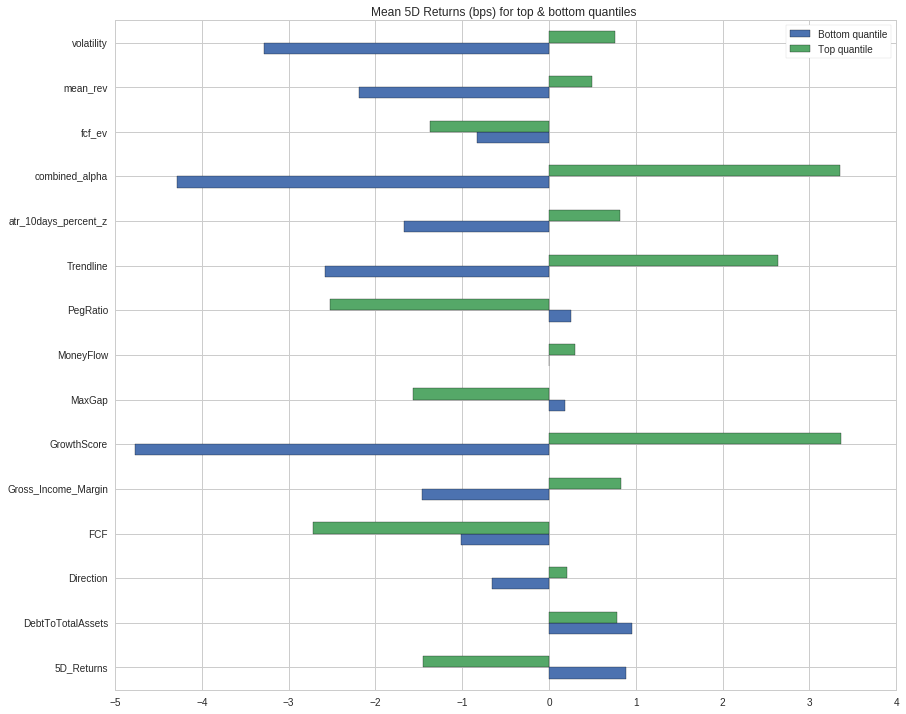

In [29]:
df = plot_top_bot(period='5D')

In [30]:
## 2015-01-01 to 2018-01-01
df['abs_diff'] = np.abs(df.iloc[:,1] - df.iloc[:,0])
df.sort_values(by=['abs_diff'], ascending=False)

,Bottom quantile,Top quantile,abs_diff
GrowthScore,-4.768742,3.358342,8.127084
combined_alpha,-4.290644,3.347232,7.637876
Trendline,-2.585702,2.634504,5.220206
volatility,-3.288369,0.765115,4.053483
PegRatio,0.249142,-2.528600,2.777742
mean_rev,-2.192923,0.488825,2.681748
atr_10days_percent_z,-1.666376,0.817394,2.483770
5D_Returns,0.886279,-1.447758,2.334037
Gross_Income_Margin,-1.460649,0.827402,2.288051
MaxGap,0.185137,-1.568460,1.753597


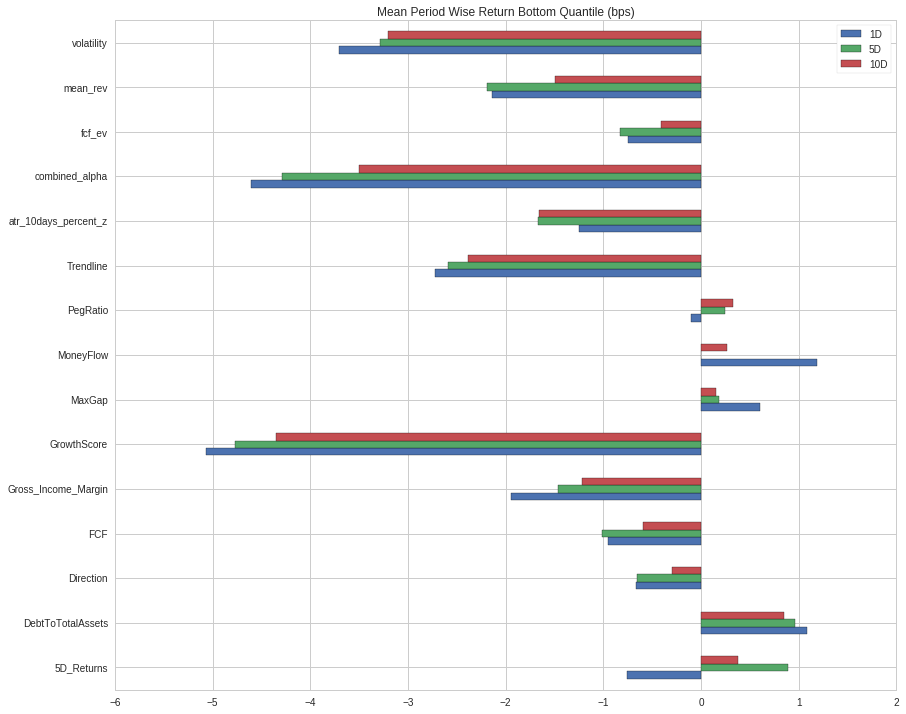

In [31]:
df = pd.concat([df.loc[1] for df in df_mu], 1)
df.columns = cols
df.T.plot(kind='barh', title='Mean Period Wise Return Bottom Quantile (bps)', figsize=fs);

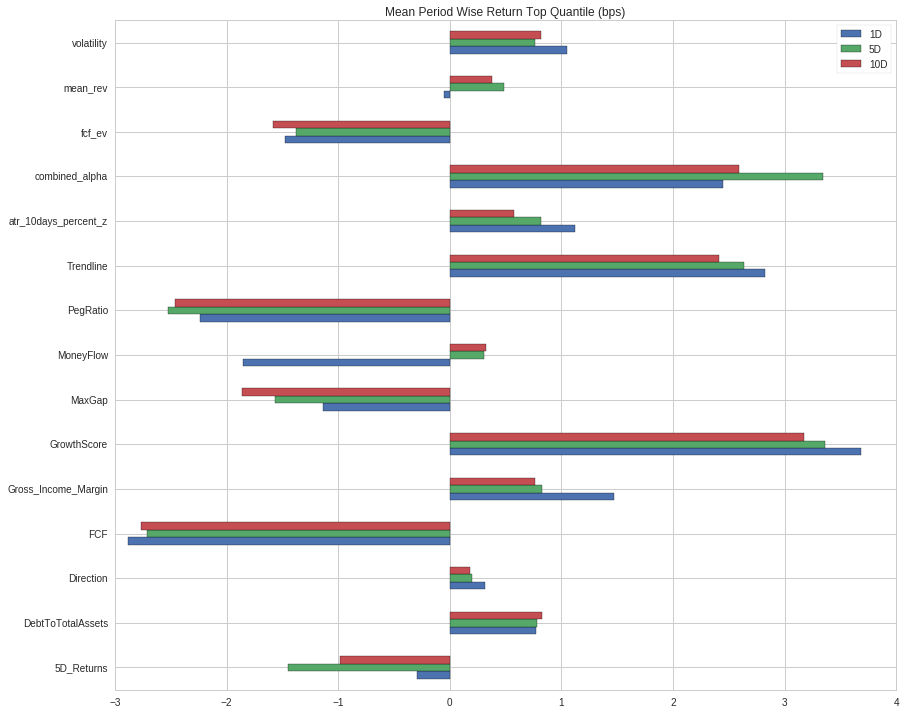

In [32]:
df = pd.concat([df.loc[5] for df in df_mu], 1)
df.columns = cols
df.T.plot(kind='barh', title='Mean Period Wise Return Top Quantile (bps)', figsize=fs);

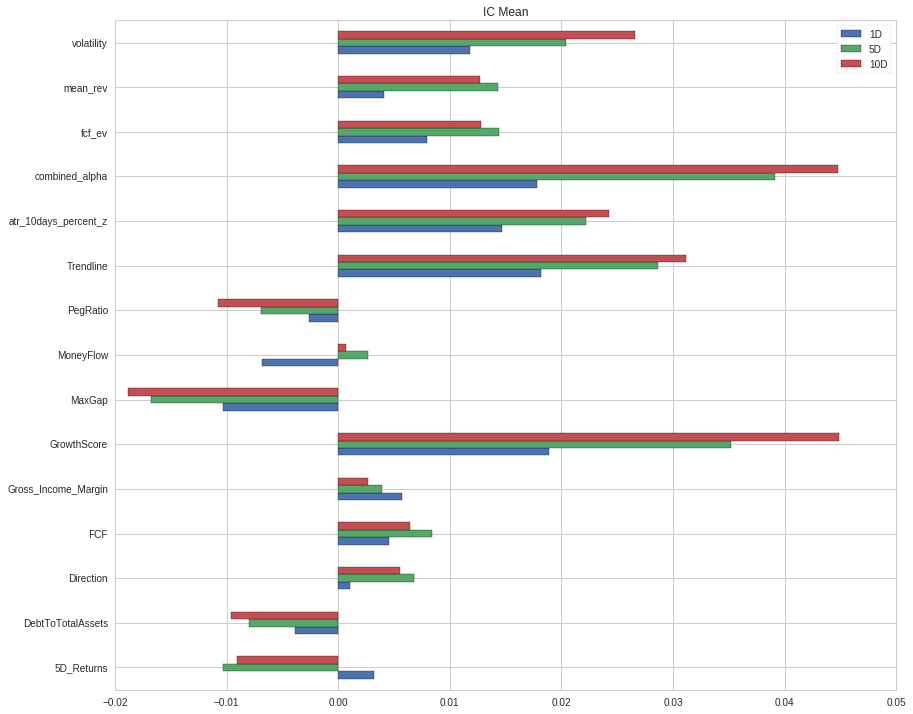

In [33]:
df = pd.concat(df_ic, 1)
df.columns = cols
df.T.plot(kind='barh', title='IC Mean', figsize=fs);

In [36]:
results_s.index = results_s.index.droplevel(1)
results_s.head()

,5D_Returns,CapEx_Vol,DebtToTotalAssets,Direction,FCF,GrossMarginChange,Gross_Income_Margin,GrowthScore,MaxGap,MoneyFlow,PegRatio,Revenue,Trendline,atr_10days_percent_z,combined_alpha,fcf_ev,mean_rev,volatility
date,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00+00:00,-0.005836,-2.678936e-17,-0.325759,-1.036289,0.392283,-0.888614,-0.344799,0.786900,-0.659480,0.565160,0.138599,-1.280695,0.534972,1.120875,-2.366134,0.397351,-0.463137,-1.303503
2017-01-03 00:00:00+00:00,0.014426,-2.678936e-17,-1.364334,-0.352858,0.023353,-0.888614,0.236524,0.689593,-0.226760,-0.447664,0.158225,0.780826,-0.012732,-0.049513,-1.421105,0.039454,-0.250282,0.243676
2017-01-03 00:00:00+00:00,-0.028021,7.807509e-01,-0.775099,1.508733,0.171173,-0.888614,0.390037,-0.636596,-0.190674,0.384314,0.260590,0.780826,-0.126047,-0.588789,2.781066,0.157456,1.328926,0.224078
2017-01-03 00:00:00+00:00,0.017435,-2.678936e-17,-0.845901,0.040713,-0.012049,1.125349,-1.268273,-0.933819,-0.143050,-0.782864,0.156349,0.780826,0.247537,0.720396,-0.611273,-0.029252,0.109194,0.223573
2017-01-03 00:00:00+00:00,0.003830,-2.678936e-17,-1.364728,-0.238945,-0.032546,-0.888614,1.193123,1.757137,-0.064307,-0.941034,0.034831,0.780826,1.639839,0.083681,2.272337,-0.037414,0.119772,0.230714


In [38]:
alpha = results_s['combined_alpha']
rets = results_s['5D_Returns']

In [39]:
print(alpha.describe().loc[['mean', 'std', 'min', 'max']])

mean    2.900748e-17
std     4.353414e+00
min    -1.327925e+02
max     5.748043e+01
Name: combined_alpha, dtype: float64


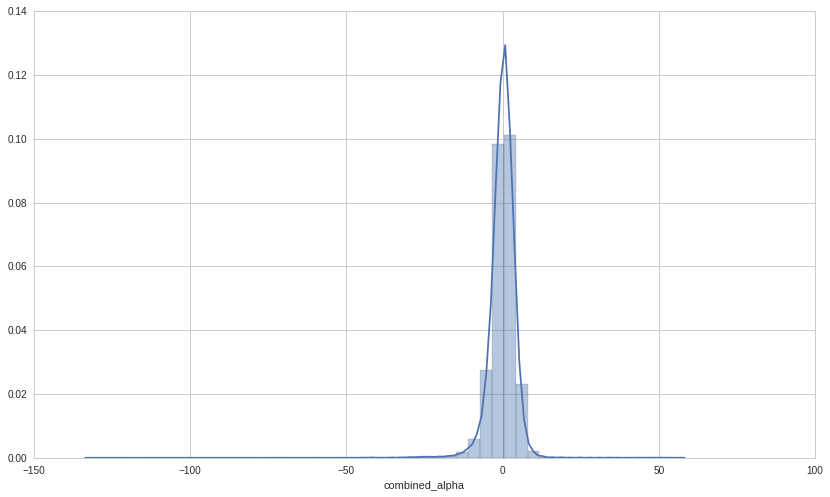

In [45]:
import seaborn as sns
sns.distplot(alpha);

In [46]:
r_s = stats.spearmanr(alpha, rets)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

Correlation Coefficient: -0.37207616322
p-value: 0.0


In [47]:
x = sm.add_constant(rets, prepend=False)
ols = sm.OLS(alpha, x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [48]:
ols.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.113       
Dependent Variable: combined_alpha   AIC:                2565252.5328
Date:               2019-04-23 21:56 BIC:                2565274.5810
No. Observations:   453191           Log-Likelihood:     -1.2826e+06 
Df Model:           1                F-statistic:        5.746e+04   
Df Residuals:       453189           Prob (F-statistic): 0.00        
R-squared:          0.113            Scale:              16.820      
----------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025    0.975] 
----------------------------------------------------------------------
5D_Returns   -34.2607    0.1429  -239.7176  0.0000  -34.5408  -33.9806
const          0.0942    0.0061    15.4363  0.0000    0.0823    0.1062
---------------------------------------------------------------------
Omnibus:            276078.574     Durbin-Watson:        1.937       
Prob(Omnibus):      0.000          Jarque-Bera (JB):     46851203.549
Skew:               -1.910         Prob(JB):             0.000       
Kurtosis:           52.664         Condition No.:        23          
=====================================================================

"""

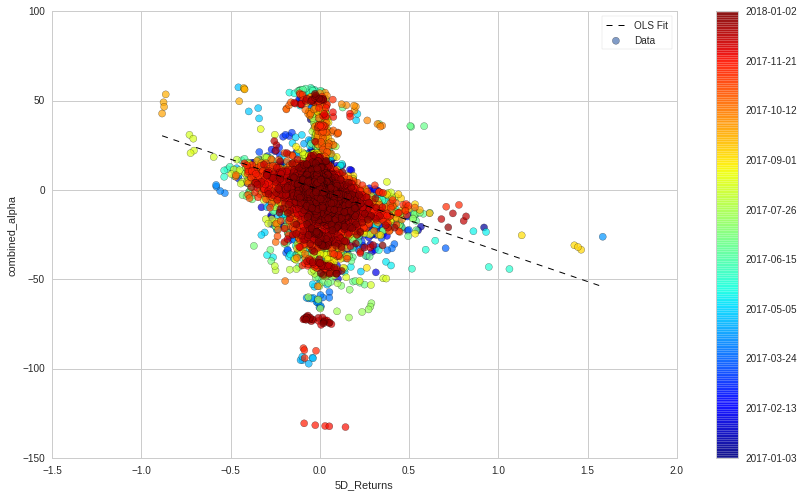

In [49]:
X = results_s
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(results))
sc = plt.scatter(results['5D_Returns'], results['combined_alpha'], s=50, c=colors, cmap=cm, 
                 edgecolor='k', alpha=0.7, label='Data')
plt.plot([x.min()[0], x.max()[0]], y_fit, 'black', linestyle='--', linewidth=1, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in X[::len(X)//9].index])
plt.xlabel('5D_Returns')
plt.ylabel('combined_alpha');

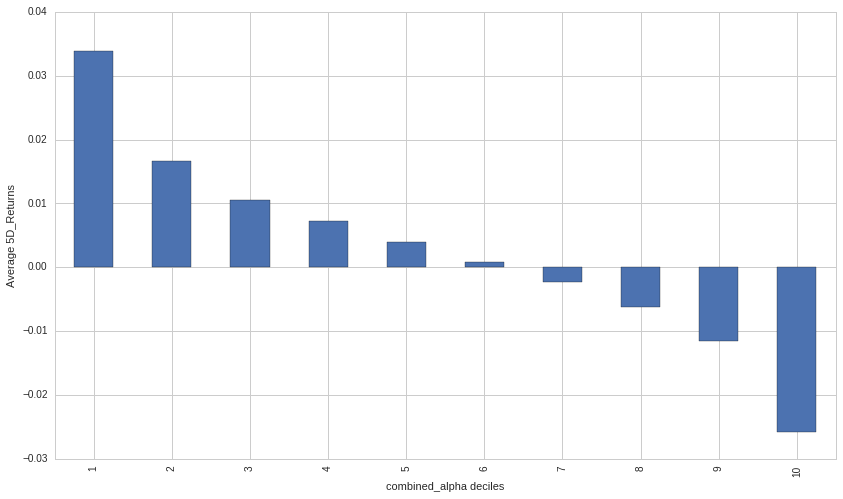

In [50]:
results_s = results_s.dropna()
results_s['decile']=pd.qcut(results_s['combined_alpha'],10,labels=False)+1
quantile_averages=results_s.groupby('decile')['5D_Returns'].apply(lambda x: x.mean())
quantile_averages.plot(kind='bar')
plt.xlabel('combined_alpha deciles')
plt.ylabel('Average 5D_Returns');

In [51]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Mtrls',
    102: 'Cnsmr Cyc',
    103: 'Fin Svs',
    104: 'Real Estate',
    205: 'Cnsmr Def',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Comm Svs',
    309: 'Energy',
    310: 'Ind',
    311: 'Tech' ,    
}

In [54]:
results['Sector_Name'] = results['Sector'].map(MORNINGSTAR_SECTOR_CODES)
results.head()

5D_Returns     CapEx_Vol  \
date                      asset                                         
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])   -0.005836 -2.678936e-17   
                          Equity(31 [ABAX])    0.014426 -2.678936e-17   
                          Equity(41 [ARCB])   -0.028021  7.807509e-01   
                          Equity(52 [ABM])     0.017435 -2.678936e-17   
                          Equity(53 [ABMD])    0.003830 -2.678936e-17   

                                             DebtToTotalAssets  Direction  \
date                      asset                                             
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])          -0.325759  -1.036289   
                          Equity(31 [ABAX])          -1.364334  -0.352858   
                          Equity(41 [ARCB])          -0.775099   1.508733   
                          Equity(52 [ABM])           -0.845901   0.040713   
                          Equity(53 [ABMD])          -1.364728  -0.238945   

                                                  FCF  GrossMarginChange  \
date                      asset                                            
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])  0.392283          -0.888614   
                          Equity(31 [ABAX])  0.023353          -0.888614   
                          Equity(41 [ARCB])  0.171173          -0.888614   
                          Equity(52 [ABM])  -0.012049           1.125349   
                          Equity(53 [ABMD]) -0.032546          -0.888614   

                                             Gross_Income_Margin  GrowthScore  \
date                      asset                                                 
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])            -0.344799     0.786900   
                          Equity(31 [ABAX])             0.236524     0.689593   
                          Equity(41 [ARCB])             0.390037    -0.636596   
                          Equity(52 [ABM])             -1.268273    -0.933819   
                          Equity(53 [ABMD])             1.193123     1.757137   

                                               MaxGap  MoneyFlow  PegRatio  \
date                      asset                                              
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -0.659480   0.565160  0.138599   
                          Equity(31 [ABAX]) -0.226760  -0.447664  0.158225   
                          Equity(41 [ARCB]) -0.190674   0.384314  0.260590   
                          Equity(52 [ABM])  -0.143050  -0.782864  0.156349   
                          Equity(53 [ABMD]) -0.064307  -0.941034  0.034831   

                                              Revenue  Sector  Trendline  \
date                      asset                                            
2017-01-03 00:00:00+00:00 Equity(24 [AAPL]) -1.280695     311   0.534972   
                          Equity(31 [ABAX])  0.780826     206  -0.012732   
                          Equity(41 [ARCB])  0.780826     310  -0.126047   
                          Equity(52 [ABM])   0.780826     310   0.247537   
                          Equity(53 [ABMD])  0.780826     206   1.639839   

                                             atr_10days_percent_z  \
date                      asset                                     
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])              1.120875   
                          Equity(31 [ABAX])             -0.049513   
                          Equity(41 [ARCB])             -0.588789   
                          Equity(52 [ABM])               0.720396   
                          Equity(53 [ABMD])              0.083681   

                                             combined_alpha    fcf_ev  \
date                      asset                                         
2017-01-03 00:00:00+00:00 Equity(24 [AAPL])       -2.366134  0.397351   
                          Equity(31 [ABAX])       -1.421105  0.039454   
                          Equity(41 

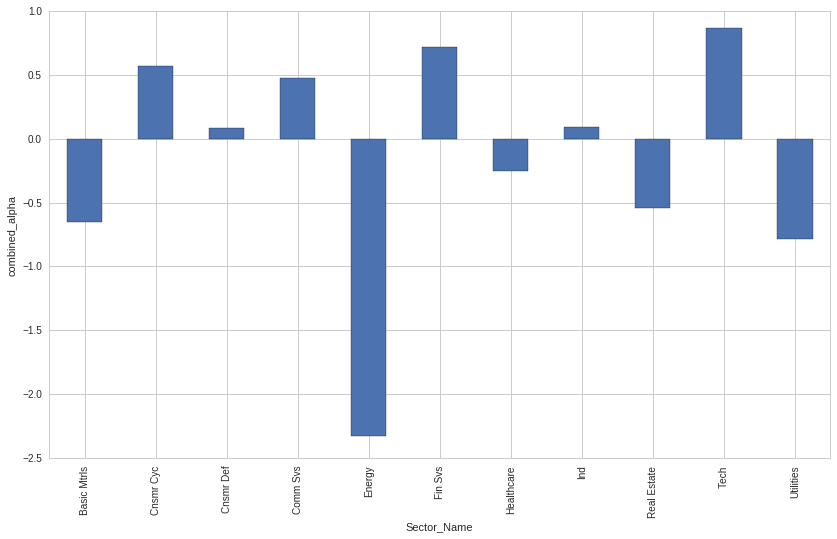

In [55]:
sector_averages = results.groupby('Sector_Name')['combined_alpha'].apply(lambda x: x.mean())
plt.ylabel('combined_alpha')
sector_averages.plot(kind='bar');

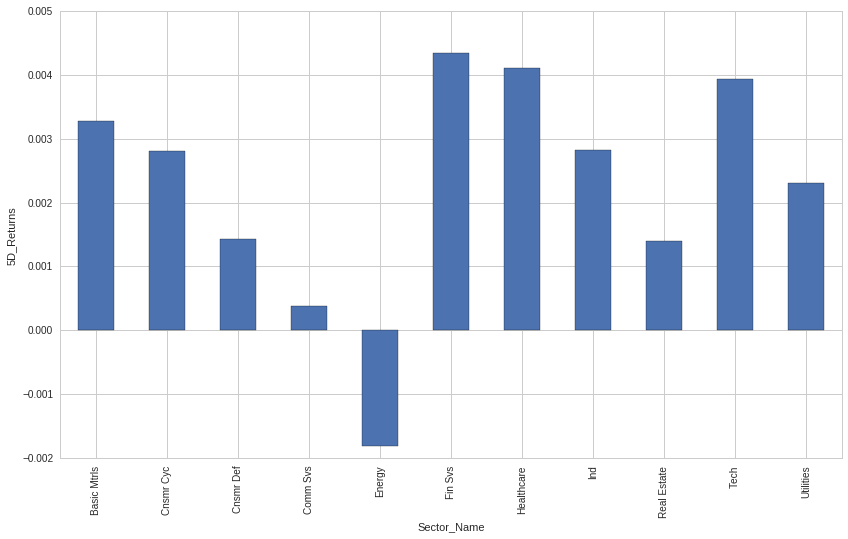

In [56]:
sector_averages = results.groupby('Sector_Name')['5D_Returns'].apply(lambda x: x.mean())
plt.ylabel('5D_Returns')
sector_averages.plot(kind='bar');

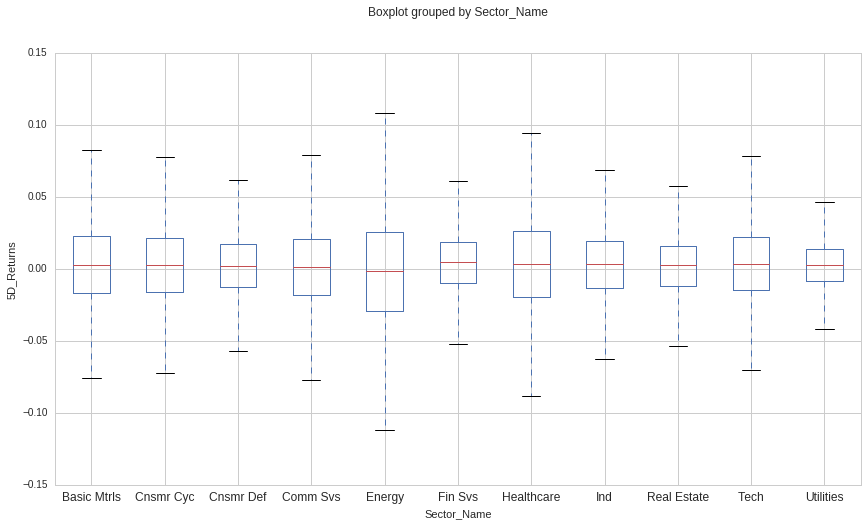

In [60]:
results.boxplot(column='5D_Returns',by='Sector_Name')
plt.ylabel('5D_Returns')
plt.title('')
plt.ylim(-0.15,0.15);

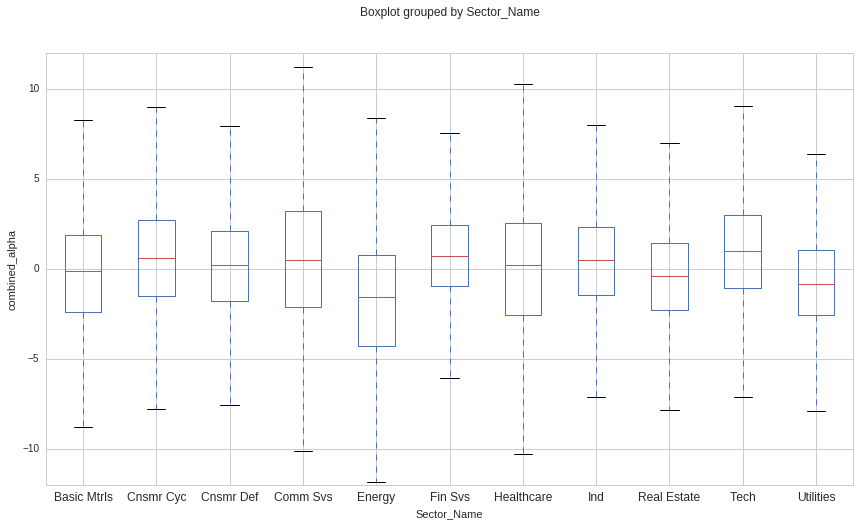

In [62]:
results.boxplot(column='combined_alpha',by='Sector_Name')
plt.ylabel('combined_alpha')
plt.title('')
plt.ylim(-12,12);

In [63]:
from quantopian.research.experimental import get_factor_returns, get_factor_loadings
import empyrical as ep

In [65]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="close_price")
#pricing = get_pricing(assets, start, end, fields="close_price")
stock_rets = pricing.pct_change()

In [66]:
def plot_ic_over_time(factor_data, label='', ax=None):
    mic = al.performance.mean_information_coefficient(factor_data)
    mic.index = mic.index.map(lambda x: int(x[:-1])) 
    ax = mic.plot(label=label, ax=ax)
    ax.set(xlabel='Days', ylabel='Mean IC')
    ax.legend()
    ax.axhline(0, ls='--', color='k')

In [67]:
# Use alphalens to combine factor values with forward returns
factor_data_total = al.utils.get_clean_factor_and_forward_returns(
    results['combined_alpha'], 
    pricing,
    periods=range(1, 15))

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


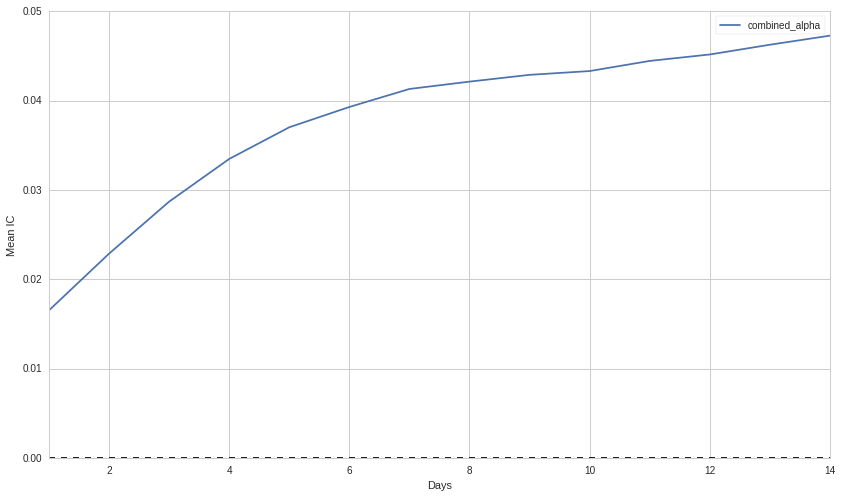

In [68]:
plot_ic_over_time(factor_data_total, label='combined_alpha')

In [69]:
# Load risk factor loadings and returns
factor_loadings = get_factor_loadings(assets, start, end + pd.Timedelta(days=30))
factor_returns = get_factor_returns(start, end + pd.Timedelta(days=30))

In [70]:
def compute_specific_returns(total_returns, factor_returns=None, factor_loadings=None, assets=None):
    if assets is not None:
        factor_loadings = get_factor_loadings(assets, start, end + pd.Timedelta(days=30))
        factor_returns = get_factor_returns(start, end + pd.Timedelta(days=30))
    elif factor_loadings is None or factor_returns is None:
        raise ValueError('Supply either assets or factor_returns and factor_loadings')
    
    factor_returns.index = factor_returns.index.set_names(['dt'])
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    common_returns = factor_loadings.mul(factor_returns).sum(axis='columns').unstack()
    specific_returns = total_returns - common_returns
    return specific_returns

In [71]:
stock_rets = pricing.pct_change()
stock_rets_specific = compute_specific_returns(stock_rets, factor_returns, factor_loadings)

In [72]:
cr_specific = ep.cum_returns(stock_rets_specific, starting_value=1)

In [73]:
factor_data_specific = al.utils.get_clean_factor_and_forward_returns(
    results['combined_alpha'], 
    cr_specific,
    periods=range(1, 15))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


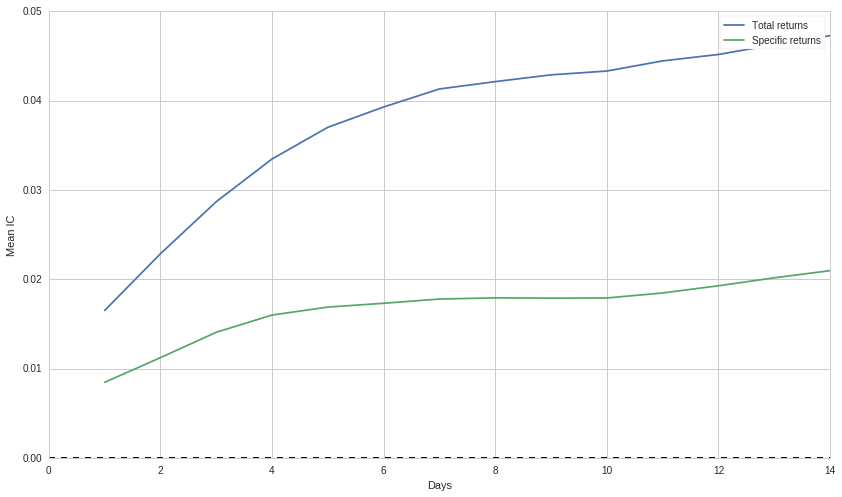

In [74]:
plot_ic_over_time(factor_data_total, label='Total returns')
plot_ic_over_time(factor_data_specific, label='Specific returns')

In [75]:
def factor_portfolio_returns(factor, pricing, equal_weight=True, delay=0):
    if equal_weight:
        factor = np.sign(factor)
        bins = (-1, 0, 1)
        quantiles = None
        zero_aware = False
    else:
        bins = None
        quantiles = 5
        zero_aware = True
        
    pos = factor.unstack().fillna(0)
    # Factor might not be daily, get trading index from pricing data and ffill
    pos = (pos / (pos.abs().sum())).reindex(pricing.index).ffill().shift(delay)
    # Fully invested, shorts show up as cash
    pos['cash'] = pos[pos < 0].sum(axis='columns')
    
    factor_and_returns = al.utils.get_clean_factor_and_forward_returns(
        pos.stack().loc[lambda x: x != 0], 
        pricing, periods=(1,), quantiles=quantiles, bins=bins, 
        zero_aware=zero_aware)
    
    return al.performance.factor_returns(factor_and_returns)['1D'], pos

portfolio_returns, portfolio_pos = factor_portfolio_returns(results['combined_alpha'], pricing, 
                                                             equal_weight=True)

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [76]:
factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
risk_exposures_portfolio, perf_attribution = pf.perf_attrib.perf_attrib(
    portfolio_returns, 
    portfolio_pos, 
    factor_returns, 
    factor_loadings, 
    pos_in_dollars=False)

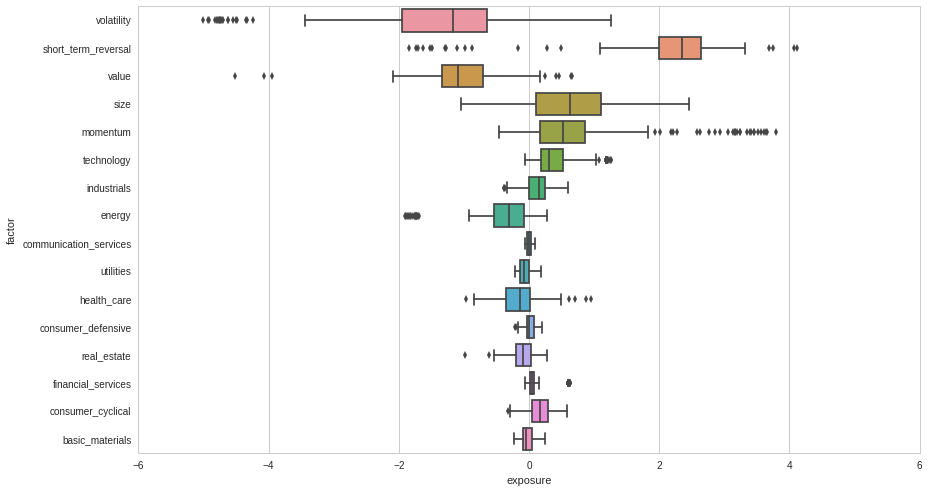

In [77]:
def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])
    
plot_exposures(risk_exposures_portfolio)

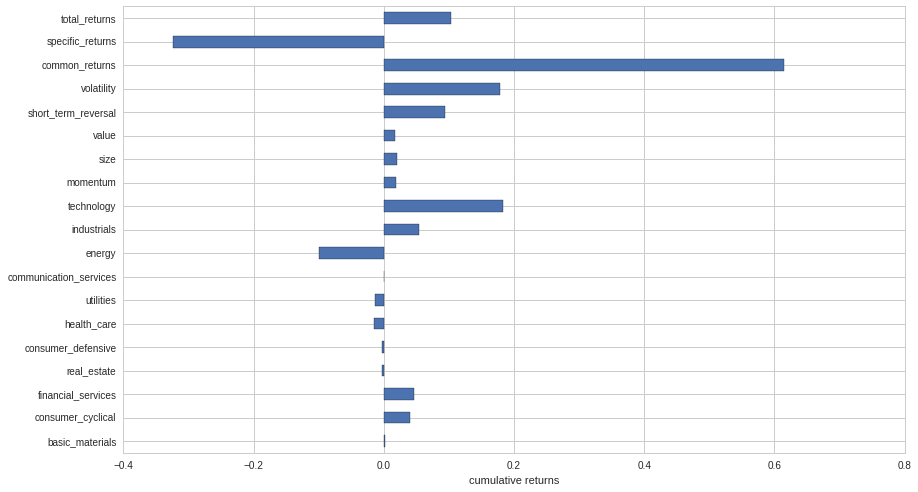

In [78]:
ep.cum_returns_final(perf_attribution).plot.barh()
plt.xlabel('cumulative returns');

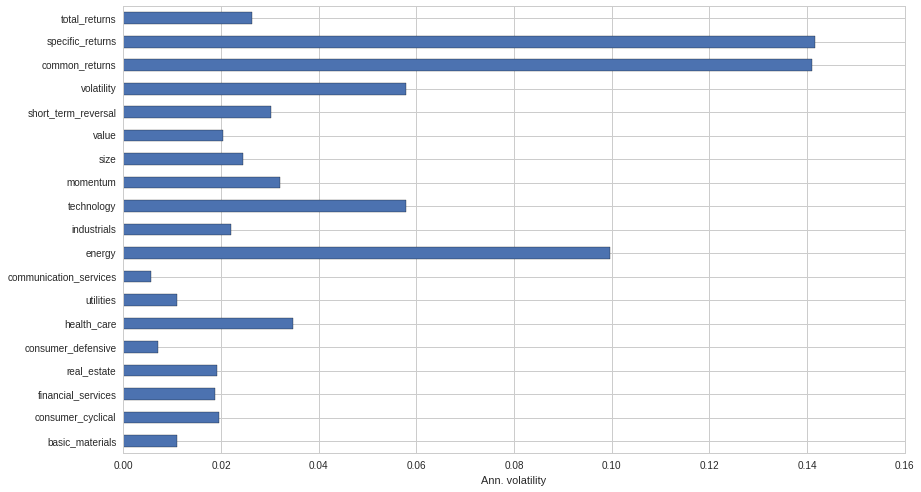

In [79]:
perf_attribution.apply(ep.annual_volatility).plot.barh()
plt.xlabel('Ann. volatility');

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


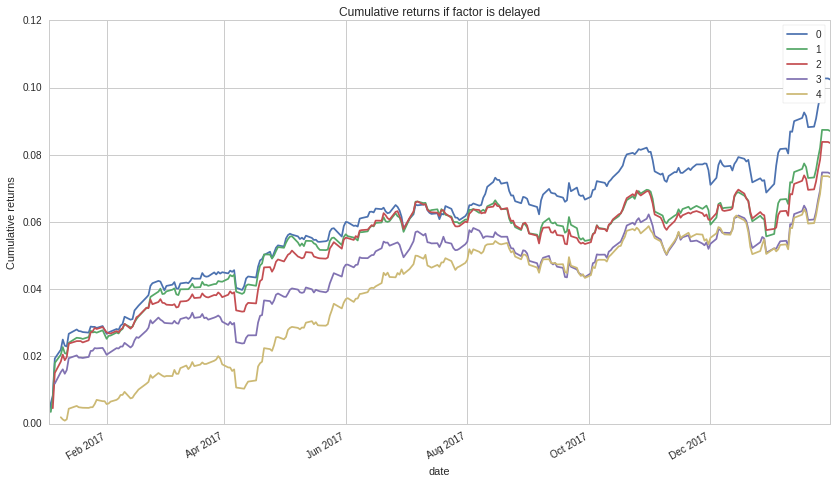

In [80]:
def plot_cum_returns_delay(factor, pricing, delay=range(5), ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for d in delay:
        portfolio_returns, _ = factor_portfolio_returns(results['combined_alpha'], pricing, delay=d)
        ep.cum_returns(portfolio_returns).plot(ax=ax, label=d)
    ax.legend()
    ax.set(ylabel='Cumulative returns', title='Cumulative returns if factor is delayed')
    
plot_cum_returns_delay(results['combined_alpha'], pricing)

In [81]:
my_factor = results['combined_alpha']
sectors = results['Sector']
asset_list = results.index.levels[1].unique()
prices = get_pricing(asset_list, start_date='2017-01-01', end_date='2018-01-01', fields='open_price')
periods = (1,3,5,10,21)

factor_data = al.utils.get_clean_factor_and_forward_returns(factor=my_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods,
                                                            quantiles = 5)

Dropped 8.9% entries from factor data: 8.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [82]:
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data,
                                                                                    by_date=True)
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data,
                                                                        by_group=False)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-132.792504,-2.087405,-5.560182,4.664669,82624,20.023556
2,-2.934965,-0.225172,-1.435973,0.576219,82482,19.989143
3,-0.749945,1.386009,0.269258,0.458462,82482,19.989143
4,0.722965,3.439992,1.880465,0.534691,82482,19.989143
5,2.330031,57.480426,4.854109,3.205722,82564,20.009015


Returns Analysis


,1D,3D,5D,10D,21D
Ann. alpha,0.109,0.105,0.107,0.101,0.094
beta,-0.057,-0.062,-0.071,-0.091,-0.152
Mean Period Wise Return Top Quantile (bps),3.262,3.167,3.373,2.828,2.487
Mean Period Wise Return Bottom Quantile (bps),-4.238,-4.442,-4.402,-4.047,-3.498
Mean Period Wise Spread (bps),7.500,7.620,7.788,6.897,6.007


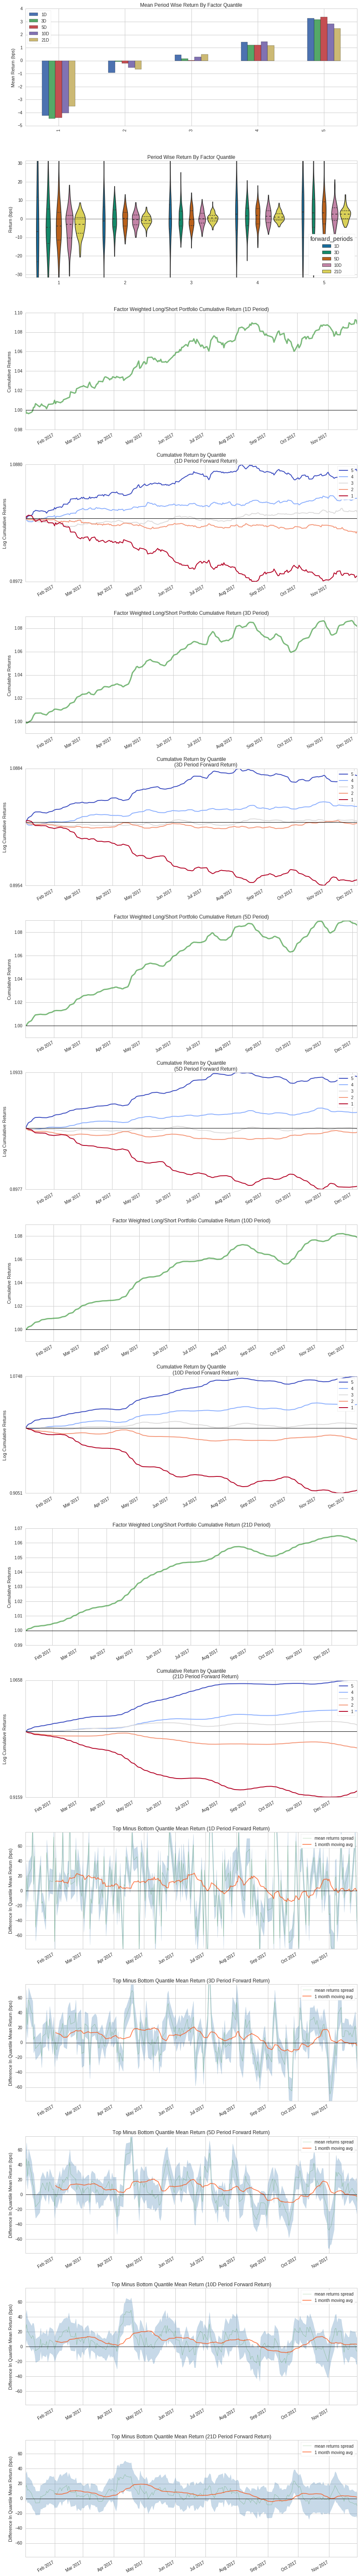

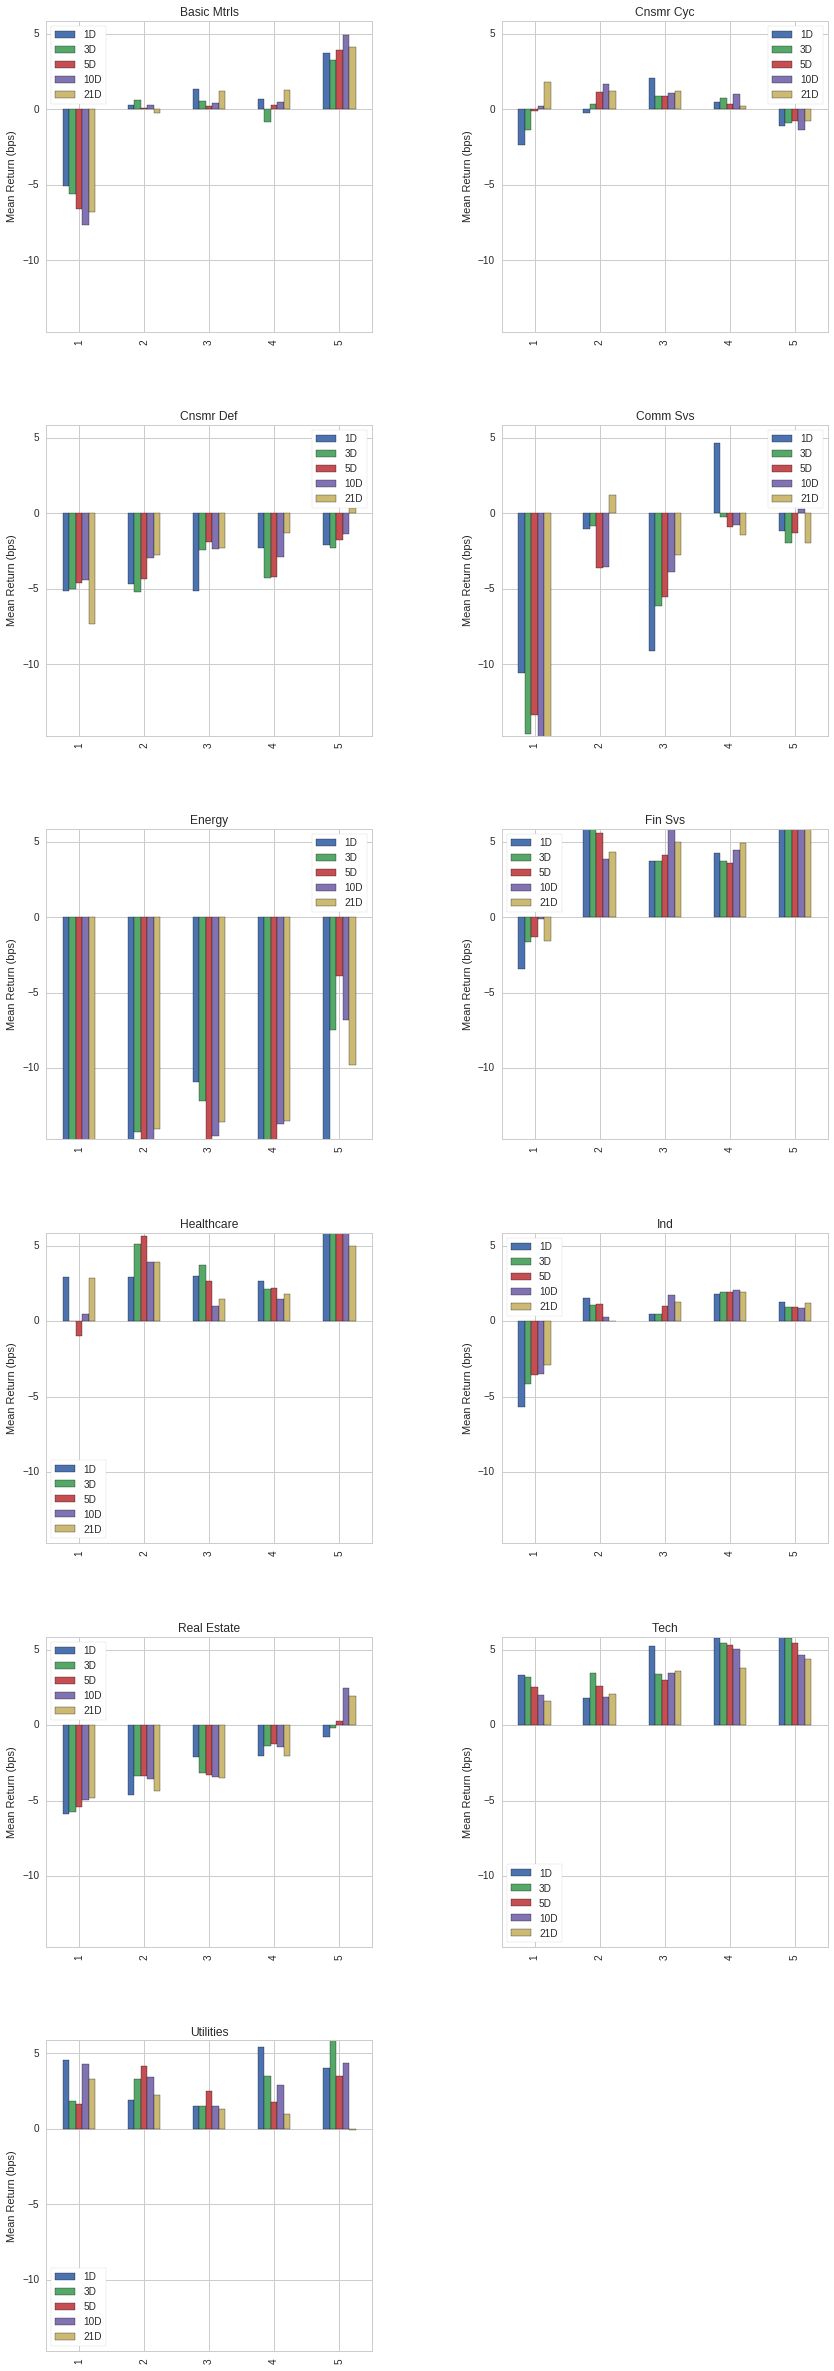

Information Analysis


,1D,3D,5D,10D,21D
IC Mean,0.021,0.032,0.041,0.050,0.062
IC Std.,0.076,0.080,0.083,0.078,0.064
Risk-Adjusted IC,0.274,0.403,0.492,0.634,0.976
t-stat(IC),4.155,6.112,7.467,9.617,14.806
p-value(IC),0.000,0.000,0.000,0.000,0.000
IC Skew,-0.136,0.150,-0.022,0.101,0.445
IC Kurtosis,0.802,1.109,0.732,0.228,0.183


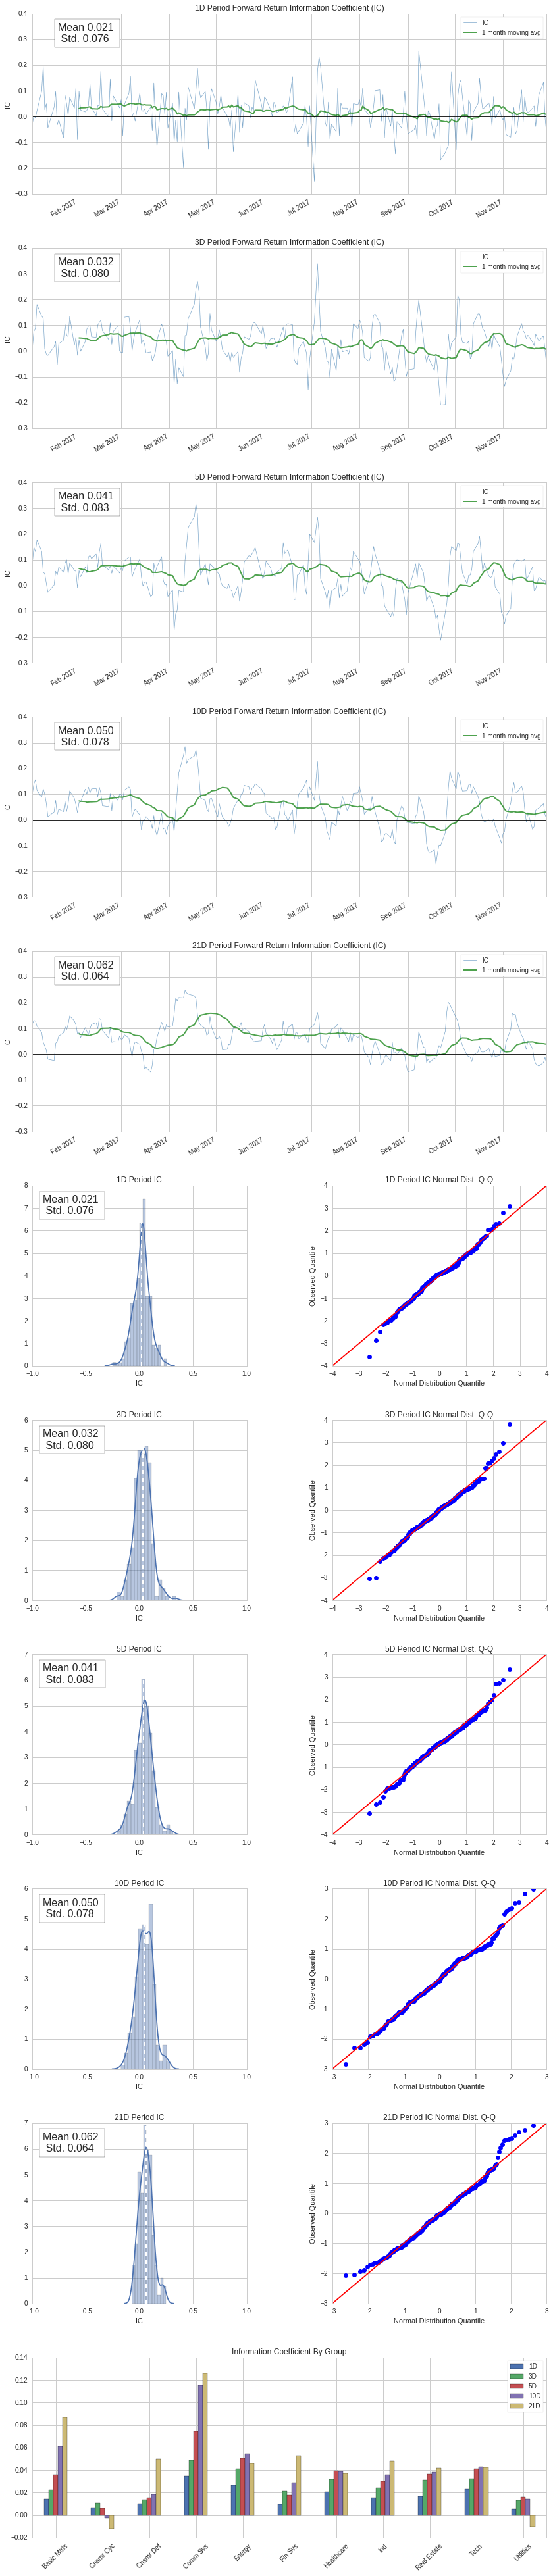

Turnover Analysis


,10D,1D,21D,3D,5D
Quantile 1 Mean Turnover,0.472,0.163,0.581,0.298,0.392
Quantile 2 Mean Turnover,0.705,0.382,0.754,0.580,0.664
Quantile 3 Mean Turnover,0.737,0.451,0.769,0.638,0.707
Quantile 4 Mean Turnover,0.713,0.408,0.757,0.602,0.678
Quantile 5 Mean Turnover,0.499,0.182,0.619,0.326,0.426


,1D,3D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.941,0.819,0.701,0.589,0.398


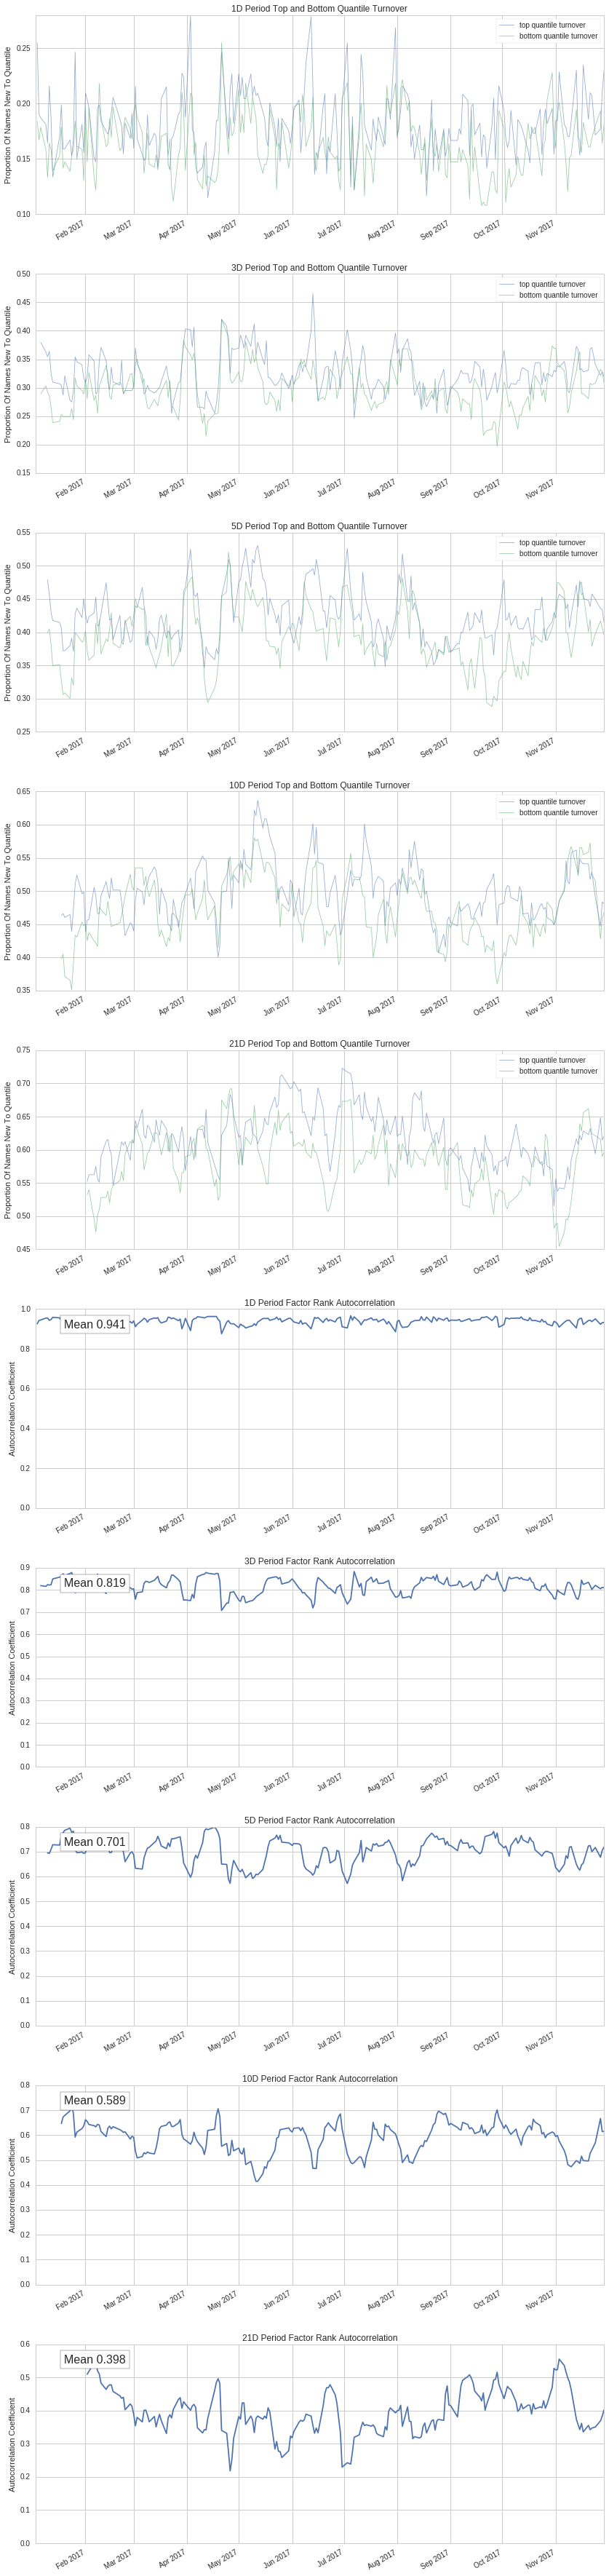

In [83]:
al.tears.create_full_tear_sheet(factor_data, by_group=True);